# Disseration Experiment - 10a
# Build the CC Neural Network Model
Ciaran Finnegan December 2023

# Import Libraries + Custom Functions

## Import Libraries

In [1]:
## Import libs
import numpy as np
import pandas as pd
import random

# Display libraries
from IPython.display import display, HTML
from prettytable import PrettyTable

import raiutils
from raiutils.exceptions import UserConfigValidationException

# Feature Data Manipulation
from sklearn.preprocessing import LabelEncoder
import warnings

# Neural Network Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Libraries required for metrics calculations
from scipy.spatial import distance
from sklearn.cluster import KMeans
import sklearn.metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.utils import resample

## Custom Functions

Dataset Visualisations

In [2]:
%run ./DS_Visualisation_Functions.ipynb

Metrics

In [3]:
%run ./XAI_Metrics_Functions.ipynb

Function 'example_function' executed in 2.0021 seconds
Result: Result, Execution Time: 2.002058744430542 seconds


Model Evaluation Functions

In [4]:
%run ./DS_Model_Build_Evaluation_Functions.ipynb

#### Suppress Warnings to clean up output

In [5]:
warnings.simplefilter(action='ignore', category=Warning)

# Data Visualisation and Exploration

## Import Data

In [6]:
ds_file_to_load = 'CreditCard_Fraud_Dataset_2KRows_v1-1_July2020.csv'
df = pd.read_csv(ds_file_to_load)

## Data Exploration

### Dataset Structure

In [7]:
# Reset default Pandas display options
pd.reset_option('display.max_columns')
pd.reset_option('display.expand_frame_repr')
pd.reset_option('display.max_colwidth')
# Display the dataframe
display(df.head())

,CardOperationsId,RunTimestamp,LOCAL_TIMESTAMP,TxnChannelCode,TxnSourceTypeCode,SourceSystemCode,AccountSourceUniqueId,CardId,CardSourceRefId,DeviceId,...,SmallOnlineAuthorizationCount.cnt.hour24,HighRiskPOSSum.acc.hour.total,HighRiskPOSSum.acc.hour.present,HighRiskPOSSum.acc.hour.past1,HighRiskPOSSum.acc.hour.past3,HighRiskPOSSum.acc.hour.past4,HighRiskPOSSum.acc.hour.past10,HighRiskPOSSum.acc.hour.past15,HighRiskPOSSum.acc.hour.past24,HighRiskPOSSum.acc.hour.past29
0,COID-1001227,2.014030e+13,2.014030e+13,POS,External,none,ACCT-24342,CARD-37899,CARD-37899,DVID-147119,...,0,0,0,0,0,0,0,0,0,0
1,COID-1001382,2.014030e+13,2.014030e+13,POS,External,none,ACCT-24342,CARD-37899,CARD-37899,DVID-44938,...,0,0,0,0,0,0,0,0,0,0
2,COID-1001539,2.014030e+13,2.014030e+13,POS,External,none,ACCT-24342,CARD-37899,CARD-37899,DVID-44938,...,0,100,0,0,0,0,0,0,0,0
3,COID-1017178,2.014030e+13,2.014030e+13,POS,External,none,ACCT-37921,CARD-4807,CARD-4807,DVID-224915,...,0,100,0,0,0,0,0,0,0,0
4,COID-1017608,2.014030e+13,2.014030e+13,POS,External,none,ACCT-4875,CARD-18065,CARD-18065,DVID-220076,...,0,0,0,0,0,0,0,0,0,0


# Feature Engineering

## Check for Missing Data

### Volume Check - Missing Data in Dataset Columns

Identify Columns with more than three-quarters of data missing

In [8]:
# Calculate the percentage of missing data in each column
missing_data_percentage = df.isnull().mean() * 100
columns_with_high_missing_data = missing_data_percentage[missing_data_percentage > 75]

In [9]:
# Convert the series to a DataFrame for better presentation
missing_data_df = pd.DataFrame(columns_with_high_missing_data).reset_index()
missing_data_df.columns = ['Dataset Column', 'PCT of Values Missing']

# Display the DataFrame
missing_data_df.style.set_properties(**{'text-align': 'left'}).set_table_styles([{
    'selector': 'th',
    'props': [('text-align', 'left')]
}])

,Dataset Column,PCT of Values Missing
0,AuthResReasonCode,100.000000
1,CurrencyCodeOrig,100.000000
2,CurrencyCodeBase,100.000000
3,Secure3d,99.124552
4,Disposition,99.840828
5,ATMDepositMax.max.day.total,100.000000
6,ATMDepositMax.max.day.present,100.000000
7,ATMDepositMax.max.day.past1,100.000000
8,ATMDepositMax.max.day.past3,100.000000
9,ATMDepositMax.max.day.past4,100.000000


In [10]:
# Confirm dataframe dimentsions before check
df.shape

(2513, 380)

In [11]:
len(df)

2513

### Correct Missing Data in Dataset - 2 Columns

1. Add 'U' for 'Unknown' to the Secure3d column. Domain advise indicates that this value is relevant for credit card fraud detection.

In [12]:
# Update missing entries in the 'Secure3d' column with a 'U' character
df['Secure3d'].fillna('U', inplace=True)

In [13]:
# Verify the update
print("Amended Data Values in Secure3d column:\n")
df['Secure3d'].value_counts()

Amended Data Values in Secure3d column:



U    2491
Y      18
N       4
Name: Secure3d, dtype: int64

' 

2. Add 'U' for 'Unknown' to the DvcPostEntryMode column. Domain advise indicates that this value is relevant for credit card fraud detection.

In [14]:
# Update missing entries in the 'DvcPosEntryMode' column with a 'U' character
df['DvcPosEntryMode'].fillna('U', inplace=True)

In [15]:
# Verify the update
print("Amended Data Values in DvcPosEntryMode column:\n")
df['DvcPosEntryMode'].value_counts()

Amended Data Values in DvcPosEntryMode column:



U               735
Card Present    573
E-Commerce      571
5               372
81              100
91               57
1                44
90               44
80                8
96                5
0                 4
Name: DvcPosEntryMode, dtype: int64

Reset threshold to 98% to remove these redundant columns

In [16]:
# Determine the threshold for missing values
threshold = 0.75 * len(df)

In [17]:
threshold

1884.75

Re-check list of columns to be dropped - ensure Secure3d not in list

In [18]:
# Identify columns with missing values greater than the threshold
missing_columns = df.columns[df.isnull().sum() > threshold]

In [19]:
# Print the columns with more than 98% missing values
print("Columns with more than 98% missing values:", missing_columns)

Columns with more than 98% missing values: Index(['AuthResReasonCode', 'CurrencyCodeOrig', 'CurrencyCodeBase',
       'Disposition', 'ATMDepositMax.max.day.total',
       'ATMDepositMax.max.day.present', 'ATMDepositMax.max.day.past1',
       'ATMDepositMax.max.day.past3', 'ATMDepositMax.max.day.past4',
       'OnlinePOSCount.cnt.present'],
      dtype='object')


### Volume Check - Missing Data in Dataset Rows

In [20]:
# Remove columns with more than 75% missing data
columns_to_drop = columns_with_high_missing_data.index.tolist()
df_dropped = df.drop(columns=columns_to_drop)

# Check if any rows in the dataset still have missing data
rows_with_missing_data = df_dropped.isnull().any(axis=1).sum()
rows_with_missing_data_percentage = (rows_with_missing_data / len(df_dropped)) * 100

print("Rows with missing values, and percentage of cells with missing data:\n")
rows_with_missing_data, rows_with_missing_data_percentage

Rows with missing values, and percentage of cells with missing data:



(25, 0.9948269001193792)

In [21]:
# Identify indices of rows with missing data
indices_with_missing_data = df_dropped[df_dropped.isnull().any(axis=1)].index.tolist()

# Select a random sample of 5 indices
random_sample_indices = random.sample(indices_with_missing_data, 5)

# Extract the rows corresponding to the random sample indices
sampled_rows_with_missing_data = df_dropped.loc[random_sample_indices]

# Display the rows in a way that allows scrolling through all values
sampled_rows_with_missing_data.style.set_properties(**{'text-align': 'left'}).set_table_styles([{
    'selector': 'th',
    'props': [('text-align', 'left')]
}]).format(None, na_rep='MISSING')

In [22]:
# Calculate the percentage of missing data in each column of the reduced dataset
missing_data_percentage_after_dropping = df_dropped.isnull().mean() * 100
columns_with_missing_data_after_dropping = missing_data_percentage_after_dropping[missing_data_percentage_after_dropping > 0]

# Convert the series to a DataFrame for better presentation
missing_data_after_dropping_df = pd.DataFrame(columns_with_missing_data_after_dropping).reset_index()
missing_data_after_dropping_df.columns = ['Dataset Column', 'PCT of Values Missing']

In [23]:
# Order the DataFrame by 'PCT of Values Missing' in descending order
missing_data_sorted_df = missing_data_after_dropping_df.sort_values(by='PCT of Values Missing', ascending=False)

# Display the sorted DataFrame
missing_data_sorted_df.style.set_properties(**{'text-align': 'left'}).set_table_styles([{
    'selector': 'th',
    'props': [('text-align', 'left')]
}])

,Dataset Column,PCT of Values Missing
1,MerchantPostalCode,0.955034
3,DevicePostalCode,0.955034
4,MerchantFSA,0.955034
5,DeviceFSA,0.955034
0,MerchantCity,0.039793
2,DeviceCity,0.039793


Quick re-check of rows with missing values

In [24]:
# Check if any rows in the dataset still have missing data
rows_with_missing_data = df_dropped.isnull().any(axis=1).sum()
rows_with_missing_data_percentage = (rows_with_missing_data / len(df_dropped)) * 100

print("Rows with missing values, and percentage of cells with missing data:\n")
rows_with_missing_data, rows_with_missing_data_percentage

Rows with missing values, and percentage of cells with missing data:



(25, 0.9948269001193792)

Quick re-check of columns with missing values

In [25]:
# Determine the threshold for missing values
threshold2 = 0.25 * len(df)

In [26]:
# Identify columns with missing values greater than the threshold
missing_columns2 = df.columns[df.isnull().sum() > threshold2]

In [27]:
# Print the columns with more than n% missing values
print("Columns with more than n% missing values:", missing_columns2)

Columns with more than n% missing values: Index(['AuthResReasonCode', 'CurrencyCodeOrig', 'CurrencyCodeBase',
       'Disposition', 'ATMDepositMax.max.day.total',
       'ATMDepositMax.max.day.present', 'ATMDepositMax.max.day.past1',
       'ATMDepositMax.max.day.past3', 'ATMDepositMax.max.day.past4',
       'OnlinePOSCount.cnt.present'],
      dtype='object')


### Remove Cols/Rows with Missing Data (over threshold)

Drop columns with missing values greater than the threshold

In [28]:
df = df.drop(columns=missing_columns)

Drop rows with missing values - less than 1% of total dataframe

In [29]:
# Set row count before removal
iOrig_rownum = len(df)

# Remove rows with missing data from the original dataframe 'df'
#df_cleaned = df_dropped.dropna()
df = df.dropna()

# Number of rows removed
#num_rows_removed = len(df) - len(df_cleaned)
num_rows_removed = iOrig_rownum - len(df)

# Aesthetically pleasing output for the number of rows removed
num_rows_removed_output = pd.DataFrame({'Description': ['Number of Rows Removed'],
                                        'Count': [num_rows_removed]})
num_rows_removed_output.style.hide_index().set_properties(**{'text-align': 'left'}).set_table_styles([{
    'selector': 'th',
    'props': [('text-align', 'left')]
}])

Description,Count
Number of Rows Removed,25


In [30]:
# Check for missing values in the cleaned dataframe
#missing_values_check = df_cleaned.isnull().sum().sum()
missing_values_check = df.isnull().sum().sum()

# Aesthetically pleasing output for the missing values check
missing_values_check_output = pd.DataFrame({'Description': ['Remaining Missing Values in DataFrame'],
                                            'Count': [missing_values_check]})
missing_values_check_output.style.hide_index().set_properties(**{'text-align': 'left'}).set_table_styles([{
    'selector': 'th',
    'props': [('text-align', 'left')]
}])

Description,Count
Remaining Missing Values in DataFrame,0


In [31]:
# Confirm dataframe dimentsions after feature column amendments
df.shape

(2488, 370)

In [32]:
# Display the first few rows of the dataset to re-check structure once any columns with 
# significant amounts of missing data have been removed
df.head()

,CardOperationsId,RunTimestamp,LOCAL_TIMESTAMP,TxnChannelCode,TxnSourceTypeCode,SourceSystemCode,AccountSourceUniqueId,CardId,CardSourceRefId,DeviceId,...,SmallOnlineAuthorizationCount.cnt.hour24,HighRiskPOSSum.acc.hour.total,HighRiskPOSSum.acc.hour.present,HighRiskPOSSum.acc.hour.past1,HighRiskPOSSum.acc.hour.past3,HighRiskPOSSum.acc.hour.past4,HighRiskPOSSum.acc.hour.past10,HighRiskPOSSum.acc.hour.past15,HighRiskPOSSum.acc.hour.past24,HighRiskPOSSum.acc.hour.past29
0,COID-1001227,2.014030e+13,2.014030e+13,POS,External,none,ACCT-24342,CARD-37899,CARD-37899,DVID-147119,...,0,0,0,0,0,0,0,0,0,0
1,COID-1001382,2.014030e+13,2.014030e+13,POS,External,none,ACCT-24342,CARD-37899,CARD-37899,DVID-44938,...,0,0,0,0,0,0,0,0,0,0
2,COID-1001539,2.014030e+13,2.014030e+13,POS,External,none,ACCT-24342,CARD-37899,CARD-37899,DVID-44938,...,0,100,0,0,0,0,0,0,0,0
3,COID-1017178,2.014030e+13,2.014030e+13,POS,External,none,ACCT-37921,CARD-4807,CARD-4807,DVID-224915,...,0,100,0,0,0,0,0,0,0,0
4,COID-1017608,2.014030e+13,2.014030e+13,POS,External,none,ACCT-4875,CARD-18065,CARD-18065,DVID-220076,...,0,0,0,0,0,0,0,0,0,0


Final check that there is no missing data.

In [33]:
# Double check for missing values in the cleaned dataframe
missing_values_double_check = df.isnull().sum().sum()
missing_values_double_check

0

## Check for 'Redundant' Data

### Identify Columns with only one value

In [34]:
# Identify columns where all values are the same and their repeated values
# unique_value_counts = df_cleaned.nunique()
unique_value_counts = df.nunique()
columns_with_single_value = unique_value_counts[unique_value_counts == 1].index
single_value_columns_with_values = pd.DataFrame({
    'Column': columns_with_single_value,
    'Repeated Value': [df[col].iloc[0] for col in columns_with_single_value]
    #'Repeated Value': [df_cleaned[col].iloc[0] for col in columns_with_single_value]
})

In [35]:
# Aesthetically pleasing output for the table
single_value_columns_with_values_styled = single_value_columns_with_values.style.hide_index().set_properties(**{'text-align': 'left'}).set_table_styles([{
    'selector': 'th',
    'props': [('text-align', 'left')]
}])

In [36]:
#single_value_columns_with_values_styled

### Remove Columns with only one value

In [37]:
# Remove these columns from the dataframe
#df = df_cleaned.drop(columns=columns_with_single_value)
df = df.drop(columns=columns_with_single_value)

In [38]:
# Confirm dataframe dimentsions after this phase of feature column amendments
df.shape

(2488, 263)

In [39]:
# Double check for missing values in the cleaned dataframe
missing_values_double_check = df.isnull().sum().sum()
missing_values_double_check

0

## Check for Outlier Data

### Identify Outlier Data in AmountOrig Column

This column represents the value of the credit card transaction

In [40]:
# Calculating Q1, Q3, and IQR for identifying outliers in 'AmountOrig'
Q1 = df['AmountOrig'].quantile(0.25)
Q3 = df['AmountOrig'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for the outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

In [41]:
# Identify outliers
outliers = df[(df['AmountOrig'] < lower_bound) | (df['AmountOrig'] > upper_bound)]
print(f"Identified {len(outliers)} outliers in the 'AmountOrig' column:")
print(outliers[['AmountOrig']].style.format("{:.2f}").set_caption("Outliers in AmountOrig"))

Identified 225 outliers in the 'AmountOrig' column:


### Remove Outlier Data in AmountOrig Column

In [42]:
# Remove rows that are in the top 95% of the 'AmountOrig' column
threshold = df['AmountOrig'].quantile(0.95)
data_filtered = df[df['AmountOrig'] <= threshold]

In [43]:
print("Original Data Size: {}".format(len(df)))
print("Filtered Data Size after removing top 95% values: {}".format(len(data_filtered)))

Original Data Size: 2488
Filtered Data Size after removing top 95% values: 2364


In [44]:
data_filtered.shape

(2364, 263)

In [45]:
df = data_filtered

### General Outlier Check

In [46]:
# Initialize an empty dataframe to hold significant outlier counts
significant_outlier_summary = pd.DataFrame(columns=['Column', 'Significant Outliers Count'])

# Iterate through each numerical column in the dataframe
for col in df.select_dtypes(include=['number']).columns:
    # Calculating Q1, Q3, and IQR
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    # Define bounds for the significant outliers (using 50 times the IQR)
    significant_upper_bound = Q3 + 50 * IQR

    # Determine significant outliers
    significant_outliers = df[df[col] > significant_upper_bound]
    significant_outlier_count = len(significant_outliers)

    # Append to summary dataframe
    significant_outlier_summary = significant_outlier_summary.append({
        'Column': col,
        'Significant Outliers Count': significant_outlier_count
    }, ignore_index=True)

In [47]:
# Displaying the results in a table format
# significant_outlier_summary.style.set_caption("Significant Outlier Counts in Each Numerical Column").hide_index()

# Dataset Exploration - Visualisations

## Generate Visualizations

#### Bar and Box Plot Visualisations

In [48]:
# Set up the target and features to be visualised

sTarget_feature = 'Fraud'
sFeature_analysis_1 = 'AmountOrig'
sFeature_analysis_2 = 'CustomerPresentIndicator'
sFeature_analysis_3 = 'ECommerceFlag'
sFeature3_ticklabel1 = 'U'
sFeature3_ticklabel2 = 'Y'

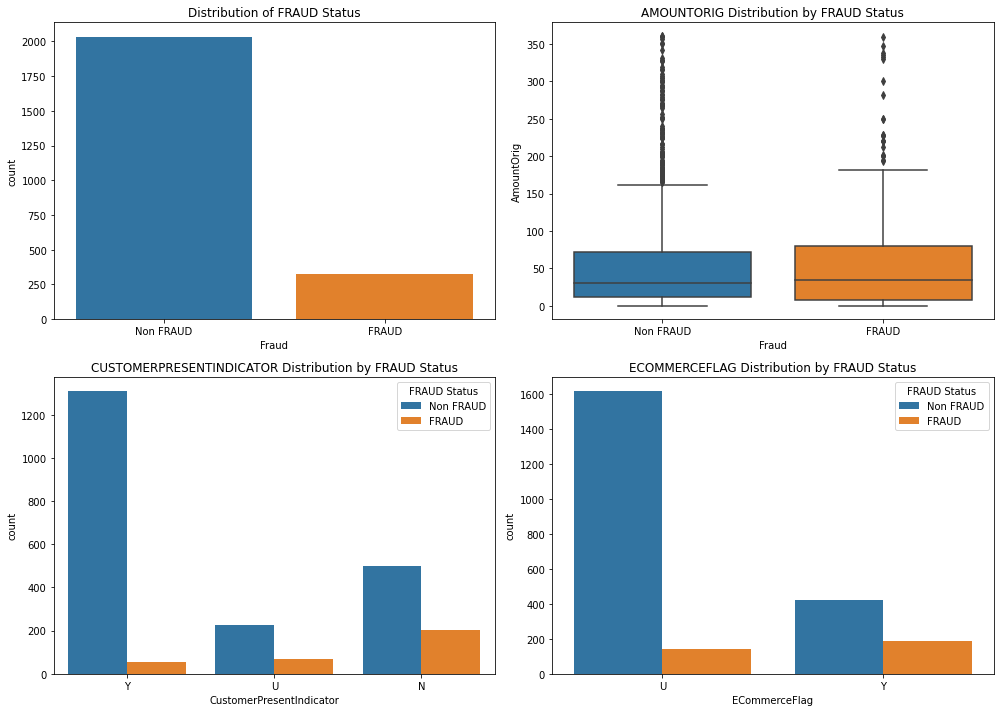

In [49]:
generate_cc_f_box_plots(df, sTarget_feature, 
                       sFeature_analysis_1, 
                       sFeature_analysis_2, 
                       sFeature_analysis_3,
                       sFeature3_ticklabel1, 
                       sFeature3_ticklabel2)